# Classification

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

import numpy as np
import albumentations as A

from scripts.models import CoinClassifier
from scripts.config import ID_TO_LABEL, ID_TO_CCY, ID_TO_EUR
from scripts.viz import plot_images
from scripts.training import train_model
from scripts.utils import split_data, get_images_from_coco, ClassificationDataset, plot_training, get_class, setup_seed

from torch.utils.data import DataLoader
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR

## Hyperparameters and Config

In [4]:
setup_seed(13)

In [5]:
# let's specify paths to training images and masks
images_path = "../data/train"
coins_path = "../data/classification"
labels_path = "../data/classification/labels.json"

annotation_path = "../data/annotations.json"
cls_path = "../data/classification"

In [6]:
# training hyperparameters
batch_size = 8

## Transformations

We first define data augmentations for more robust model. Since our backbones are pretrained on Imagenet, we apply dataset specific normalization to the transformations.

In [7]:
# cut coins from images if necessary and save them as separate images
get_images_from_coco(images_path, annotation_path, cls_path)

Files already there, good to go!


In [8]:
# define data augmentation for train and validation
train_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.RandomRotate90(),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True)
])

valid_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True)  # imagenet specific
])

## Modelling

### Predicting Currency

We first build a classifier that will separate between EUR and CHF.

#### Datasets and DataLoaders

In [9]:
# split the image paths into train and validation
images_train, images_val, labels_train, labels_val = split_data(coins_path, 0.2, "classification", labels_path, "ccy")

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

We use `Segmentation Models Pytorch` for model generation, then we define training arguments and train the model

In [10]:
model = CoinClassifier(num_classes=2, coin_type="ccy")

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.head.parameters(), lr=0.0005)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [ ]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=20
)

In [ ]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Predicting EUR

Now we can build a classifier to distinguish between EUR coin types.

#### Datasets and DataLoaders

In [71]:
# split the image paths into train and validation
images_train, images_val, labels_train, labels_val = split_data(coins_path, 0.2, "classification", labels_path, "eur")

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [158]:
model = CoinClassifier(num_classes=8, coin_type="eur", freeze=False)

In [159]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [160]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=30
)

Epoch:   1. Train.      Loss: 1.843 | f1: 0.331: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]
Epoch:   1. Validation. Loss: 1.444 | f1: 0.550: 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]
Epoch:   2. Train.      Loss: 1.113 | f1: 0.650: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
Epoch:   2. Validation. Loss: 0.958 | f1: 0.600: 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]
Epoch:   3. Train.      Loss: 0.704 | f1: 0.775: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
Epoch:   3. Validation. Loss: 0.737 | f1: 0.675: 100%|██████████| 5/5 [00:00<00:00,  8.51it/s]
Epoch:   4. Train.      Loss: 0.443 | f1: 0.906: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]
Epoch:   4. Validation. Loss: 0.570 | f1: 0.775: 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]
Epoch:   5. Train.      Loss: 0.243 | f1: 0.981: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]
Epoch:   5. Validation. Loss: 0.464 | f1: 0.875: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]
Epoch:   6. Train.      Loss: 0.188 | f1

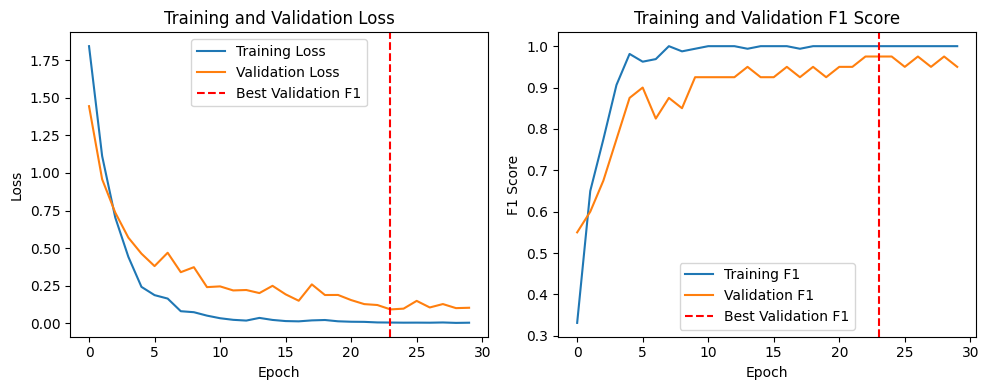

In [161]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Predicting CHF heads or tails

#### Datasets and DataLoaders

In [92]:
# split the image paths into train and validation
labels_path = "../data/classification/heads_tails.json"
images_train, images_val, labels_train, labels_val = split_data(coins_path, 0.2, "classification", labels_path,
                                                                "heads-tails")

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [101]:
model = CoinClassifier(num_classes=2, coin_type="heads-tails")

In [102]:
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.head.parameters(), lr=0.001)
scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

In [103]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs
)

Epoch:   1. Train.      Loss: 0.643 | f1: 0.679: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s]
Epoch:   1. Validation. Loss: 0.441 | f1: 0.792: 100%|██████████| 4/4 [00:00<00:00,  8.34it/s]
Epoch:   2. Train.      Loss: 0.404 | f1: 0.821: 100%|██████████| 14/14 [00:01<00:00,  7.32it/s]
Epoch:   2. Validation. Loss: 0.303 | f1: 0.875: 100%|██████████| 4/4 [00:00<00:00,  8.45it/s]
Epoch:   3. Train.      Loss: 0.294 | f1: 0.857: 100%|██████████| 14/14 [00:01<00:00,  7.33it/s]
Epoch:   3. Validation. Loss: 0.286 | f1: 1.000: 100%|██████████| 4/4 [00:00<00:00,  8.50it/s]
Epoch:   4. Train.      Loss: 0.227 | f1: 0.938: 100%|██████████| 14/14 [00:02<00:00,  6.80it/s]
Epoch:   4. Validation. Loss: 0.223 | f1: 0.969: 100%|██████████| 4/4 [00:00<00:00,  7.63it/s]
Epoch:   5. Train.      Loss: 0.175 | f1: 0.982: 100%|██████████| 14/14 [00:02<00:00,  5.93it/s]
Epoch:   5. Validation. Loss: 0.193 | f1: 0.969: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
Epoch:   6. Train.      Loss: 0.154 | f1

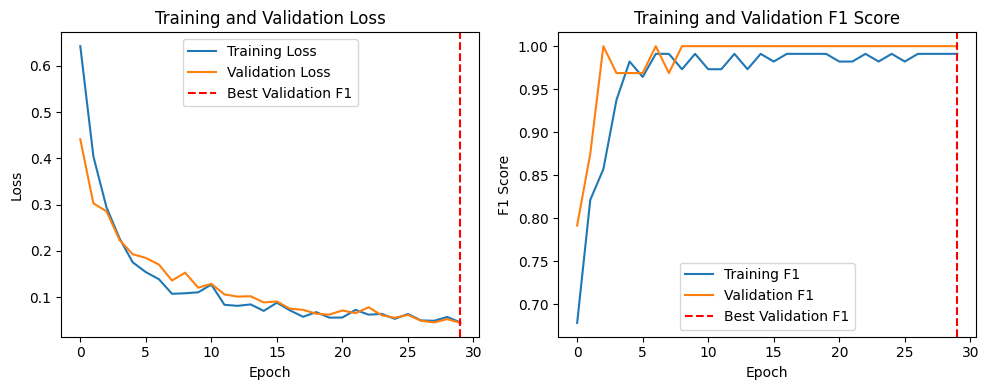

In [104]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

#### Inference

In [ ]:
eval_loader = DataLoader(val_ds, batch_size=4, shuffle=False)  # TODO: filter
id_to_label = np.vectorize(lambda x: ID_TO_LABEL.get(x, "Unknown"))

for images, labels, radii in eval_loader:
    predicted = get_class(model, images, radii, id_to_label)
    actual = id_to_label(labels.numpy())

    img_labels = [f"pred: {a1}, actual: {a2}" for a1, a2 in zip(predicted, actual)]
    images = torch.clamp(images, 0, 1).cpu().numpy()

    images_dict = dict(zip(img_labels, images))

    plot_images(**images_dict)

### Predicting CHF tails

#### Datasets and DataLoaders

In [11]:
# define data augmentation for train and validation
train_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.RandomRotate90(p=1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=1),
    A.RandomBrightnessContrast(p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True)
])

valid_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True)
])

In [12]:
# split the image paths into train and validation
labels_path = "../data/classification/chf_tails.json"
images_train, images_val, labels_train, labels_val = split_data(
    coins_path, 0.2, "classification", labels_path, "chf-tails"
)

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [27]:
model = CoinClassifier(num_classes=7, coin_type="chf-tails", freeze=False)

In [28]:
num_epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.00002, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,
)

In [29]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs
)

Epoch:   1. Train.      Loss: 1.914 | f1: 0.236: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]
Epoch:   1. Validation. Loss: 1.608 | f1: 0.403: 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]
Epoch:   2. Train.      Loss: 1.352 | f1: 0.556: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]
Epoch:   2. Validation. Loss: 1.253 | f1: 0.750: 100%|██████████| 3/3 [00:00<00:00,  9.54it/s]
Epoch:   3. Train.      Loss: 1.090 | f1: 0.694: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]
Epoch:   3. Validation. Loss: 1.144 | f1: 0.639: 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]
Epoch:   4. Train.      Loss: 1.011 | f1: 0.764: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]
Epoch:   4. Validation. Loss: 1.106 | f1: 0.639: 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]
Epoch:   5. Train.      Loss: 1.001 | f1: 0.736: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]
Epoch:   5. Validation. Loss: 1.103 | f1: 0.639: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]
Epoch:   6. Train.      Loss: 0.965 | f1: 0.736: 1

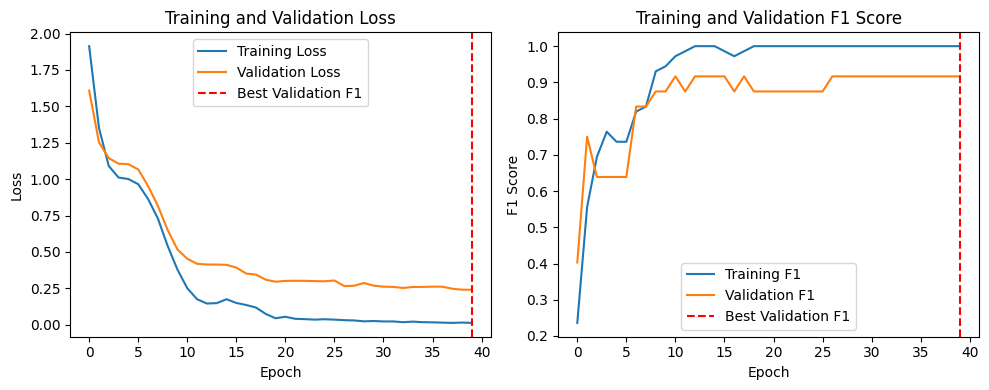

In [30]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Predicting CHF heads

#### Datasets and Dataloaders

In [28]:
# split the image paths into train and validation
labels_path = "../data/classification/chf_heads.json"
images_train, images_val, labels_train, labels_val = split_data(
    coins_path, 0.2, "classification", labels_path, "chf-heads"
)

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [29]:
model = CoinClassifier(num_classes=3, coin_type="chf-heads", freeze=False)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.00001)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [31]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=60
)

Epoch:   1. Train.      Loss: 0.924 | f1: 0.550: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]
Epoch:   1. Validation. Loss: 0.854 | f1: 0.750: 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]
Epoch:   2. Train.      Loss: 0.754 | f1: 0.675: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]
Epoch:   2. Validation. Loss: 0.784 | f1: 0.875: 100%|██████████| 2/2 [00:00<00:00,  7.76it/s]
Epoch:   3. Train.      Loss: 0.602 | f1: 0.825: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
Epoch:   3. Validation. Loss: 0.684 | f1: 0.938: 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]
Epoch:   4. Train.      Loss: 0.591 | f1: 0.775: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
Epoch:   4. Validation. Loss: 0.654 | f1: 0.938: 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]
Epoch:   5. Train.      Loss: 0.463 | f1: 0.875: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]
Epoch:   5. Validation. Loss: 0.610 | f1: 0.938: 100%|██████████| 2/2 [00:00<00:00,  7.68it/s]
Epoch:   6. Train.      Loss: 0.358 | f1: 0.900: 1

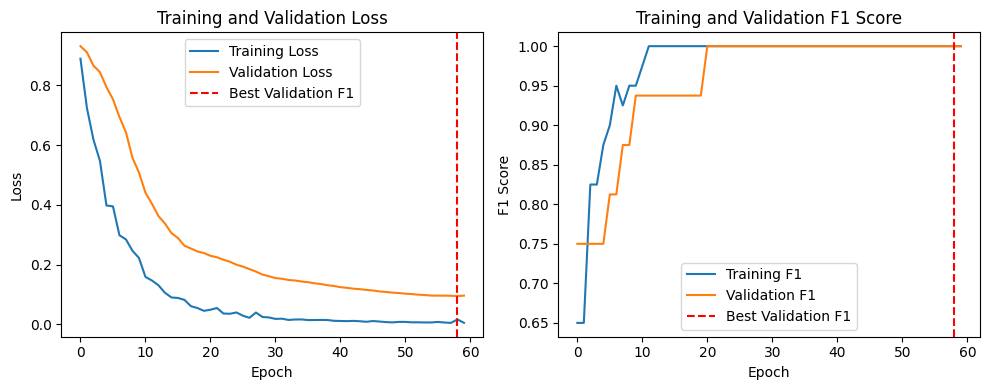

In [21]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)